In [3]:
pip install imageio

     |████████████████████████████████| 3.3 MB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 11.0 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.1
    Uninstalling Pillow-8.3.1:
      Successfully uninstalled Pillow-8.3.1
Note: you may need to restart the kernel to use updated packages.


In [13]:
#! -*- coding: utf-8 -*-
# Keras implement of NICE (Non-linear Independent Components Estimation)
# https://arxiv.org/abs/1410.8516

from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import imageio
import matplotlib.pyplot as plt

In [18]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
print('image size: ', image_size)
original_dim = image_size * image_size #28x28
x_train = np.reshape(x_train, [-1, original_dim])
print('x_train reshaped: ',x_train.shape)
x_test = np.reshape(x_test, [-1, original_dim])
print('x_test reshaped: ',x_test.shape)
x_train = x_train.astype('float32') / 255
print('x_train norm: ',x_train.shape)
x_test = x_test.astype('float32') / 255
print('x_test norm: ',x_test.shape)

image size:  28
x_train reshaped:  (60000, 784)
x_test reshaped:  (10000, 784)
x_train norm:  (60000, 784)
x_test norm:  (10000, 784)


In [20]:
class Shuffle(Layer):
    """打乱层，提供两种方式打乱输入维度
    一种是直接反转，一种是随机打乱，默认是直接反转维度
    """
    #A camada de embaralhamento fornece duas maneiras de embaralhar a dimensão de entrada:
    #Um é inversão direta, o outro é aleatório, o padrão é inverter diretamente a dimensão
    
    def __init__(self, idxs=None, mode='reverse', **kwargs):
        super(Shuffle, self).__init__(**kwargs)
        self.idxs = idxs
        self.mode = mode
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        if self.idxs == None:
            self.idxs = list(range(v_dim))
            if self.mode == 'reverse':
                self.idxs = self.idxs[::-1]
            elif self.mode == 'random':
                np.random.shuffle(self.idxs)
        inputs = K.transpose(inputs)
        outputs = K.gather(inputs, self.idxs)
        outputs = K.transpose(outputs)
        return outputs
    def inverse(self):
        v_dim = len(self.idxs)
        _ = sorted(zip(range(v_dim), self.idxs), key=lambda s: s[1])
        reverse_idxs = [i[0] for i in _]
        return Shuffle(reverse_idxs)


class SplitVector(Layer):
    """将输入分区为两部分，交错分区
    """
    #Particionar a entrada em duas partes, intercalar as partições
    def __init__(self, **kwargs):
        super(SplitVector, self).__init__(**kwargs)
    def call(self, inputs):
        v_dim = K.int_shape(inputs)[-1]
        inputs = K.reshape(inputs, (-1, v_dim//2, 2))
        return [inputs[:,:,0], inputs[:,:,1]]
    def compute_output_shape(self, input_shape):
        v_dim = input_shape[-1]
        return [(None, v_dim//2), (None, v_dim//2)]
    def inverse(self):
        layer = ConcatVector()
        return layer


class ConcatVector(Layer):
    """将分区的两部分重新合并
    """#Mescle novamente as duas partes da partição
    def __init__(self, **kwargs):
        super(ConcatVector, self).__init__(**kwargs)
    def call(self, inputs):
        inputs = [K.expand_dims(i, 2) for i in inputs]
        inputs = K.concatenate(inputs, 2)
        return K.reshape(inputs, (-1, np.prod(K.int_shape(inputs)[1:])))
    def compute_output_shape(self, input_shape):
        return (None, sum([i[-1] for i in input_shape]))
    def inverse(self):
        layer = SplitVector()
        return layer


class AddCouple(Layer):
    """加性耦合层
    """#camada de acoplamento aditivo
    def __init__(self, isinverse=False, **kwargs):
        self.isinverse = isinverse
        super(AddCouple, self).__init__(**kwargs)
    def call(self, inputs):
        part1, part2, mpart1 = inputs
        if self.isinverse:
            return [part1, part2 + mpart1] # 逆为加 inverso para mais
        else:
            return [part1, part2 - mpart1] # 正为减 positivo para menos
    def compute_output_shape(self, input_shape): 
        return [input_shape[0], input_shape[1]]
    def inverse(self):
        layer = AddCouple(True)
        return layer


class Scale(Layer):
    """尺度变换层 camada de escala
    """
    def __init__(self, **kwargs):
        super(Scale, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, input_shape[1]),
                                      initializer='glorot_normal',
                                      trainable=True)
    def call(self, inputs):
        self.add_loss(-K.sum(self.kernel)) # 对数行列式
        return K.exp(self.kernel) * inputs
    def inverse(self):
        scale = K.exp(-self.kernel)
        return Lambda(lambda x: scale * x)


def build_basic_model(v_dim):
    """基础模型，即加性耦合层中的m O modelo base, ou seja, m na camada de acoplamento aditivo
    """
    _in = Input(shape = (v_dim,))
    _ = _in
    for i in range(5):
        _ = Dense(1000, activation='relu')(_)
    _ = Dense(v_dim, activation='relu')(_)
    return Model(_in, _)



In [21]:
shuffle1 = Shuffle()
shuffle2 = Shuffle()
shuffle3 = Shuffle()
shuffle4 = Shuffle()

split = SplitVector()
couple = AddCouple()
concat = ConcatVector()
scale = Scale()

basic_model_1 = build_basic_model(original_dim//2)
basic_model_2 = build_basic_model(original_dim//2)
basic_model_3 = build_basic_model(original_dim//2)
basic_model_4 = build_basic_model(original_dim//2)


x_in = Input(shape=(original_dim,))
x = x_in

# 给输入加入负噪声
# Adicione ruído negativo à entrada
x = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(x)

x = shuffle1(x)
x1,x2 = split(x)
mx1 = basic_model_1(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle2(x)
x1,x2 = split(x)
mx1 = basic_model_2(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle3(x)
x1,x2 = split(x)
mx1 = basic_model_3(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = shuffle4(x)
x1,x2 = split(x)
mx1 = basic_model_4(x1)
x1, x2 = couple([x1, x2, mx1])
x = concat([x1, x2])

x = scale(x)


encoder = Model(x_in, x)
encoder.summary()
encoder.compile(loss=lambda y_true,y_pred: K.sum(0.5 * y_pred**2, 1),
                optimizer='adam')


checkpoint = ModelCheckpoint(filepath='./best_encoder.weights',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

encoder.fit(x_train,
            x_train,
            batch_size=128,
            epochs=30,
            validation_data=(x_test, x_test))
            #callbacks=[checkpoint])


#encoder.load_weights('./best_encoder.weights')



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 784)          0           input_10[0][0]                   
__________________________________________________________________________________________________
shuffle_9 (Shuffle)             (None, 784)          0           lambda_3[0][0]                   
__________________________________________________________________________________________________
split_vector_6 (SplitVector)    [(None, 392), (None, 0           shuffle_9[0][0]                  
                                                                 shuffle_10[0][0]                 
          

/home/lab_acustica/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lab_acustica/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lab_acustica/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 133us/step - loss: -168.6567 - val_loss: -349.4303
Epoch 2/30
60000/60000 [==============================] - 6s 108us/step - loss: -520.2730 - val_loss: -685.6898
Epoch 3/30
60000/60000 [==============================] - 6s 108us/step - loss: -837.6411 - val_loss: -977.7642
Epoch 4/30
60000/60000 [==============================] - 7s 109us/step - loss: -1102.3503 - val_loss: -1206.9747
Epoch 5/30
60000/60000 [==============================] - 6s 107us/step - loss: -1310.2130 - val_loss: -1385.1445
Epoch 6/30
60000/60000 [==============================] - 7s 115us/step - loss: -1475.0468 - val_loss: -1527.8449
Epoch 7/30
60000/60000 [==============================] - 7s 109us/step - loss: -1610.3921 - val_loss: -1643.4679
Epoch 8/30
60000/60000 [==============================] - 7s 110us/step - loss: -1721.0806 - val_loss: -1739.6185
Epoch 9/30
60000/60000 [====================

In [22]:
# 搭建逆模型（生成模型），将所有操作倒过来执行
# Construir o modelo inverso (gerar o modelo) e realizar todas as operações no sentido inverso

x = x_in
x = scale.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_4(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle4.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_3(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle3.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_2(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle2.inverse()(x)

x1,x2 = concat.inverse()(x)
mx1 = basic_model_1(x1)
x1, x2 = couple.inverse()([x1, x2, mx1])
x = split.inverse()([x1, x2])
x = shuffle1.inverse()(x)

decoder = Model(x_in, x)

In [29]:
# 采样查看生成效果
# Amostragem para visualizar o efeito de geração

n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.array(np.random.randn(1, original_dim)) * 0.75 # 标准差取0.75而不是1
        #O desvio padrão leva 0,75 em vez de 1
        x_decoded = decoder.predict(z_sample)
        #print("decoded", x_decoded.shape, x_decoded)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

figure = np.clip(figure*255, 0, 255)

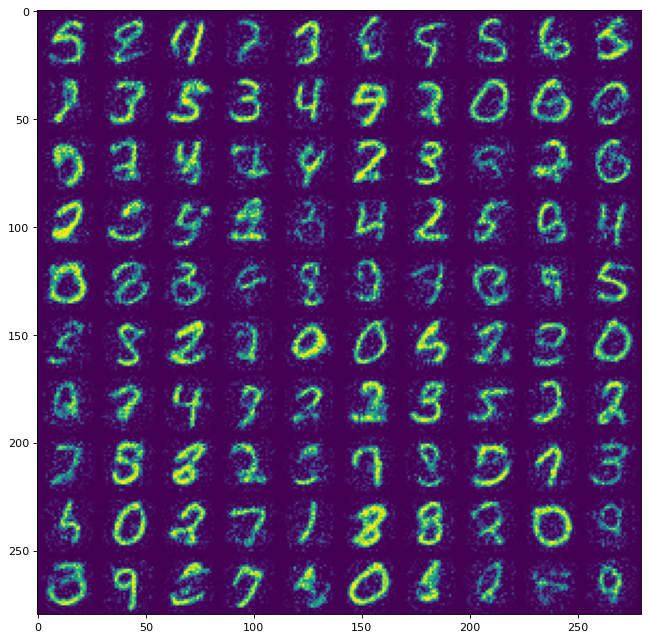

In [30]:
plt.figure(figsize=(12,10), dpi=80)
plt.imshow(figure)